<a href="https://colab.research.google.com/github/hueyqing/LIN373_Project_SentimentAnalysis/blob/master/SentimentAnalysis_MovieReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W A R N I N G ! ! ! ! ! ! ! ! ! ! 
Re-running our entire notebook will probably take more than 7 hours


# Sentiment Analysis of Text for Moview Review Prediction
Project by: Group 8, Tan Huey Qing [ ht7627 ] & Sarang Rastogi [ sr45936 ]<br><br>
__GOAL:__<br>
To be able to predict the sentiment of movie reviews as accurately as possible<br><br>
__WHAT IS SENTIMENT ANALYSIS?__<br>
Sentiment Analysis can be defined as the process of computationally determining whether a piece of writing is positive, negative, neutral etc. In context of speech it can be coined as ‘opinion mining’ to derive the opinion or attitude of a speaker. <br><br>
__DATA/ RESOURCES:__<br>
We have chosen the IMDB dataset of 50k movie reviews from here:<br>
https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews#IMDB%20Dataset.csv<br><br>
__MACHINE LEARNING ALGORITHMS/ MODELS:__<br>
To study the correlation between the sentiment analysis results and movie review sentiment prediction, we aim to implement algorithms of Naive Bayes, logistic Regression and SVMs depending on the trend the factor we choose displays and find the best model.<br><br>
__ACCURACY/ EVALUATION:__
We aim to find the accuracy of our sentiment analysis using k-fold cross validation and analysing the accuracy of predictions using multiple classifiers such as neural networks and ensemble methods. 

# 1. Load Data & General Preprocessing

In [1]:
# We appreciate the source below for allowing us to use their dataset. 
# Licensing information: 
# @InProceedings{maas-EtAl:2011:ACL-HLT2011,
#   author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
#   title     = {Learning Word Vectors for Sentiment Analysis},
#   booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
#   month     = {June},
#   year      = {2011},
#   address   = {Portland, Oregon, USA},
#   publisher = {Association for Computational Linguistics},
#   pages     = {142--150},
#   url       = {http://www.aclweb.org/anthology/P11-1015}
# }

In [2]:
## ALL REQUIRED IMPORTS

from gensim.models import Word2Vec
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import STOPWORDS
from keras import layers
from keras.constraints import maxnorm
from keras.layers import Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import statistics 
import tensorflow as tf
import time
import warnings

# !python -m pip install -U keras
# !python -m pip install -U tensorflow
# !python -m pip install smart-open==1.9.0

Using TensorFlow backend.


In [3]:
%%time
## LOAD DATA & ENCODE POS/NEG TO 1/0

df = pd.read_csv('IMDB_Dataset.csv')
df["review"] = df["review"].str.lower()
print(df.head())

for row in range (len(df)):
    if (df['sentiment'].iloc[row] == 'positive'):
        df['sentiment'].iloc[row] = 1
    else:
        df['sentiment'].iloc[row] = 0 
print (df.head())

                                              review sentiment
0  one of the other reviewers has mentioned that ...  positive
1  a wonderful little production. <br /><br />the...  positive
2  i thought this was a wonderful way to spend ti...  positive
3  basically there's a family where a little boy ...  negative
4  petter mattei's "love in the time of money" is...  positive
                                              review  sentiment
0  one of the other reviewers has mentioned that ...          1
1  a wonderful little production. <br /><br />the...          1
2  i thought this was a wonderful way to spend ti...          1
3  basically there's a family where a little boy ...          0
4  petter mattei's "love in the time of money" is...          1
Wall time: 1min 50s


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null int64
dtypes: int64(1), object(1)
memory usage: 781.4+ KB

(50000, 2)

1    25000
0    25000
Name: sentiment, dtype: int64

Average review length: 1309.43102


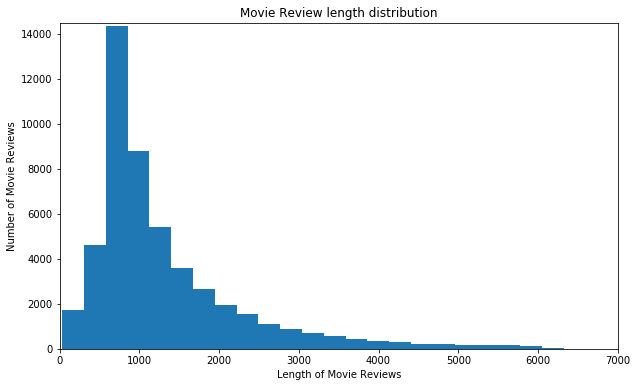

<Figure size 432x288 with 0 Axes>

In [4]:
## ANALYZE DATA

df.info()
print("\n" + str(df.shape))
print("\n" + str(df.sentiment.value_counts()))
lengths = [len(sample) for sample in list(df['review'])]
print("\n" + "Average review length: " + str(statistics.mean(lengths)))
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(df['review'])], 50)
plt.xlabel('Length of Movie Reviews')
plt.ylabel('Number of Movie Reviews')
plt.title('Movie Review length distribution')
plt.axis([0, 7000, 0, 14500])
plt.show()
plt.savefig("MovieReviewLengthDistribution")

# 2. Preprocess Data with Train Test Split & Count Vectorizer
This is to be used for Naive Bayes and Logistic Regression

In [5]:
%%time
## PROCESS DATA FOR NB & LR WITH TRAIN TEST SPLIT & VECTORIZER

text_data = df.drop(['sentiment'], axis = 1)
# print (text_data)
labels = df.drop(['review'], axis = 1)
# print (labels)
docs_train, docs_test, y_train, y_test = train_test_split(text_data, labels, test_size = 0.2, random_state = 1000)
# print (docs_train)

# vectorize the training data
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(docs_train.review)
# print(len(vectorizer.get_feature_names()))
# print(vectorizer.get_feature_names()[:1000])
# print(X_train[0])

Wall time: 14.4 s


 ### 2.1 Generate Naive Bayes  Model

In [6]:
%%time
## NAIVE BAYES MODEL WITH SINGLE TRAIN/TEST/SPLIT

# REMEMBER to test out different parameters
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
# vectorize the test data and predict 
X_test = vectorizer.transform(docs_test.review)
# print(np.shape(X_test))
y_hat_nb = nb_model.predict(X_test)
# print (y_hat_nb)
probs = []
probs = nb_model.predict_proba(X_test)
# print (probs)
# get accuracy score
accuracy_score_nb = metrics.accuracy_score(y_test, y_hat_nb)

# print out some data
print("nb_model accuracy is : ", accuracy_score_nb)
print("classification report:\n", metrics.classification_report(y_test, y_hat_nb))

# print(np.shape(X_test))

C:\Users\hueyq\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


nb_model accuracy is :  0.8415
classification report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.85      5054
           1       0.86      0.81      0.83      4946

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Wall time: 3.82 s


Area:  0.9140351330579198
TPR(Sensitivity): [0.         0.19187222 0.19227659 ... 0.99979782 1.         1.        ]
TNR(Specificity): [1.         0.9908983  0.9908983  ... 0.00356154 0.00356154 0.        ]


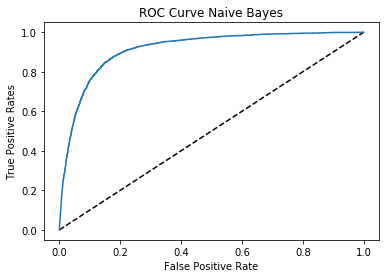

In [7]:
## PLOT RESULTS FOR  NAIVE BAYES

'''
mat = confusion_matrix(X_train, y_train)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=X_train_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');
'''

probs1 = []
fpr, tpr = [], []
for i in range (0, len(probs)):
    probs1.append(probs[i][1])
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs1)
score = metrics.roc_auc_score(y_test, probs1)
print ("Area: ", score)

# Plotting ROC 
plt.plot([0,1],[0,1],'k--') #plot the diagonal line
plt.plot(fpr, tpr, label='NB') #plot the ROC curve
print("TPR(Sensitivity): " + str(tpr))
print("TNR(Specificity): " + str(1-fpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rates')
plt.title('ROC Curve Naive Bayes')
plt.savefig('ROC_nb.png')
plt.show()

In [8]:
## NAIVE BAYES MODEL WITH K-FOLD CROSS VALIDATION

nb_xval_model = MultinomialNB()
X = vectorizer.fit_transform(df.review)
y = df.sentiment
nb_xval_scores = cross_val_score(nb_xval_model, X,y, cv=10)

print("Accuracy for Naive Bayes with Cross Validation: %0.4f (+/- %0.4f)" % (nb_xval_scores.mean(), nb_xval_scores.std() * 2))

Accuracy for Naive Bayes with Cross Validation: 0.8499 (+/- 0.0062)


 ### 2.2 Generate Logistic Regression Model

In [9]:
%%time
## GENERATE LOGISTIC REGRESSION MODEL WITH SKLEARN

text_data = df.drop(['sentiment'], axis = 1)
# print (text_data)
labels = df.drop(['review'], axis = 1)
# print (labels)
docs_train, docs_test, y_train, y_test = train_test_split(text_data, labels, test_size = 0.2, random_state = 1000)
# print (docs_train)

# vectorize the training data
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(docs_train.review)
# REMEMBER to test out different parameters
lr_model = LogisticRegression(solver = 'saga')
lr_model.fit(X_train, y_train)

# vectorize the test data and predict 
X_test = vectorizer.transform(docs_test.review)

y_hat_lr = lr_model.predict(X_test)
probs_lr = []
probs_lr = lr_model.predict_proba(X_test)

# get accuracy score
accuracy_score_lr = metrics.accuracy_score(y_test, y_hat_lr)

# print out some data
print("lr_model accuracy is : ", metrics.accuracy_score(y_test, y_hat_lr))
print("classification report:\n", metrics.classification_report(y_test, y_hat_lr))



C:\Users\hueyq\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\hueyq\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


lr_model accuracy is :  0.882
classification report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      5054
           1       0.87      0.89      0.88      4946

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Wall time: 47.1 s


Area:  0.9467259861190209
TPR(Sensitivity): [0.00000000e+00 2.02183583e-04 4.81196927e-02 ... 9.99797816e-01
 1.00000000e+00 1.00000000e+00]
TNR(Specificity): [1.         1.         1.         ... 0.02374357 0.02374357 0.        ]


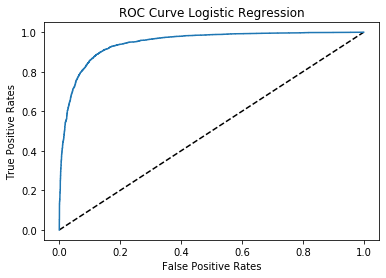

In [10]:
## PLOT RESULTS FOR LOGISTIC REGRESSION

'''mat = confusion_matrix(X_train, y_train)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=X_train_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');'''
probs1_lr = []
fpr, tpr = [], []
for i in range (0, len(probs_lr)):
    probs1_lr.append(probs_lr[i][1])
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs1_lr)
score = metrics.roc_auc_score(y_test, probs1_lr)
print ("Area: ", score)

# Plotting ROC 
plt.plot([0,1],[0,1],'k--') #plot the diagonal line
plt.plot(fpr, tpr, label='NB') #plot the ROC curve
print("TPR(Sensitivity): " + str(tpr))
print("TNR(Specificity): " + str(1-fpr))
plt.xlabel('False Positive Rates')
plt.ylabel('True Positive Rates')
plt.title('ROC Curve Logistic Regression')
plt.savefig('ROC_lr.png')
plt.show()

In [11]:
## LOGISTIC REGRESSION MODEL WITH K-FOLD CROSS VALIDATION

# Try different parameters
lr_xval_model = LogisticRegression(random_state = 3, solver = 'saga')
X = vectorizer.fit_transform(df.review)
y = df.sentiment
lr_xval_scores = cross_val_score(lr_xval_model, X,y, cv=10)

print("Accuracy for Logistic Regression: %0.4f (+/- %0.4f)" % (lr_xval_scores.mean(), lr_xval_scores.std() * 2))


C:\Users\hueyq\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy for Logistic Regression: 0.8834 (+/- 0.0081)


### 2.3 Generate Neural Net Model

In [12]:
%%time
## IMPLEMENT NEURAL NETS

text_data = df['review'].values
labels = df['sentiment'].values 

docs_train, docs_test, y_train, y_test = train_test_split(text_data, labels, test_size=0.2, random_state=1000)
docs_train, docs_val, y_train, y_val = train_test_split(docs_train, y_train, test_size=0.1, random_state=1000)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(docs_train)
X_test = vectorizer.transform(docs_test)
X_val = vectorizer.transform(docs_val)

input_dim = X_train.shape[1]
print(input_dim)
nn_model = Sequential()
# nn_model.add(layers.Dense(10, input_dim=input_dim, activation='relu', kernel_constraint=maxnorm(3)))
nn_model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(layers.Dense(1, activation='sigmoid'))

nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_model.summary()

history = nn_model.fit(X_train, y_train, epochs=3, 
          validation_data=(X_val, y_val), ## specifying the validation set 
          batch_size=50)
loss, nn_accuracy = nn_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(nn_accuracy))

# NO DROPOUT batchsize= 50, epoch:3, test accuracy 0.8808 with kernel constraint
# WITH DROPOUT batchsize= 50, epoch:3, test accuracy 0.8962

88808
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                888090    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 888,101
Trainable params: 888,101
Non-trainable params: 0
_________________________________________________________________
Train on 36000 samples, validate on 4000 samples
Epoch 1/3
36000/36000 [==============================] - 58s 2ms/step - loss: 0.3403 - accuracy: 0.8682 - val_loss: 0.2676 - val_accuracy: 0.8947
Epoch 2/3
36000/36000 [==============================] - 59s 2ms/step - loss: 0.1733 - accuracy: 0.9394 - val_loss: 0.2613 - val_accuracy: 0.9028
Epoch 3/3
36000/36000 [========

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


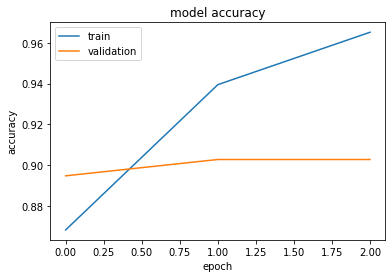

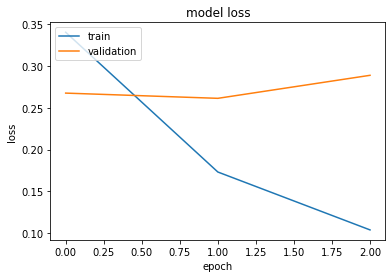

In [13]:
## PLOT NEURAL NET GRAPHS 

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("accuracy_dropout.png")
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("loss_dropout.png")
plt.show()

### 2.4 Generate Support Vector Machine

In [14]:
%%time
## GENERATE SVM

start_time = time.time()
svmachine = svm.SVC(gamma='auto')
print (svmachine.get_params().keys())
#pipe = Pipeline([('scaler', scaler), ('pca', pca), ('svm', svmachine)])
#svmachine.fit(data_X, data_Y)
#scores = cross_val_score(svmachine, df["review"], df["sentiment"], cv=2)
svm_xval_scores = cross_val_score(svmachine, X, y, cv=2)
print("Scores:", svm_xval_scores)
print("Accuracy:", svm_xval_scores.mean()*100)
print("--- %s seconds ---" % (time.time() - start_time))

dict_keys(['C', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])
Scores: [0.72208 0.72268]
Accuracy: 72.238
--- 3874.1024057865143 seconds ---
Wall time: 1h 4min 34s


# 3. Learn Word Embeddings with Word2Vec
And use them in models

In [15]:
%%time
## PREPROCESS DATA FOR WORD2VEC

sentList = []
for review in df[:50000]["review"]:
    sentences = nltk.sent_tokenize(review)
    str1 = ''.join(sentences)
    sentences = preprocess_string(str1)
    sentList.append(sentences)

"""  
from nltk.stem.porter import *
from gensim.utils import simple_preprocess
words = []
for mylist in sentList:    
    for myword in mylist:
        words.append(myword)
print(words)
print("\n")
for review in df[:100]["review"]:
    sentences = nltk.sent_tokenize(review)   
print(sentences)
for review in df[:10]["review"]:
    sentences = nltk.sent_tokenize(review)
    for sentence in sentences:
        tokenized.append(nltk.word_tokenize(sentence))
for mylist in tokenized:    
    for myword in mylist:
        words.append(myword)
#print(words)
stemmer = PorterStemmer()
stems = [stemmer.stem(w) for w in words]
print(' '.join(stems))
"""

Wall time: 1min 27s


'  \nfrom nltk.stem.porter import *\nfrom gensim.utils import simple_preprocess\nwords = []\nfor mylist in sentList:    \n    for myword in mylist:\n        words.append(myword)\nprint(words)\nprint("\n")\nfor review in df[:100]["review"]:\n    sentences = nltk.sent_tokenize(review)   \nprint(sentences)\nfor review in df[:10]["review"]:\n    sentences = nltk.sent_tokenize(review)\n    for sentence in sentences:\n        tokenized.append(nltk.word_tokenize(sentence))\nfor mylist in tokenized:    \n    for myword in mylist:\n        words.append(myword)\n#print(words)\nstemmer = PorterStemmer()\nstems = [stemmer.stem(w) for w in words]\nprint(\' \'.join(stems))\n'

In [16]:
%%time
## GENERATE WORD2VEC MODEL

w2v_model = Word2Vec(sentList, size=100,  min_count=2) 
# change min count later
# print(w2v_model)

# summarize vocabulary
words = list(w2v_model.wv.vocab)
print(words)

# save model for later in binary format to save space.
w2v_model.save('w2v_model_50k.bin')
# save non binary to be loaded into other models (?)
w2v_model.wv.save_word2vec_format('w2v_50k.txt', binary=False)

# to review embedded vector for a specific token:
# print(w2v_model.wv[<<INSERT TOKEN>>])


['review', 'mention', 'watch', 'episod', 'hook', 'right', 'exactli', 'happen', 'thing', 'struck', 'brutal', 'unflinch', 'scene', 'violenc', 'set', 'word', 'trust', 'faint', 'heart', 'timid', 'pull', 'punch', 'regard', 'drug', 'sex', 'hardcor', 'classic', 'us', 'call', 'nicknam', 'given', 'oswald', 'maximum', 'secur', 'state', 'penitentari', 'focus', 'mainli', 'emerald', 'citi', 'experiment', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inward', 'privaci', 'high', 'agenda', 'home', 'aryan', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', 'scuffl', 'death', 'stare', 'dodgi', 'deal', 'shadi', 'agreement', 'far', 'awai', 'main', 'appeal', 'fact', 'goe', 'show', 'wouldn', 'dare', 'forget', 'pretti', 'pictur', 'paint', 'mainstream', 'audienc', 'charm', 'romanc', 'mess', 'saw', 'nasti', 'surreal', 'couldn', 'readi', 'develop', 'tast', 'got', 'accustom', 'level', 'graphic', 'injustic', 'crook', 'guard', 'sold', 'nickel', 'inmat', 'kill', 'order', 'manner', 'middl', '

Wall time: 37.1 s


Word2Vec(vocab=41949, size=100, alpha=0.025)


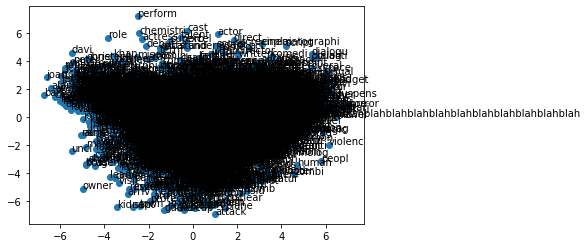

Wall time: 3min 51s


In [17]:
%%time
## PLOT WORD2VEC WORD EMBEDDINGS USING PCA

warnings.filterwarnings("ignore")

# load model
w2v_model = Word2Vec.load('w2v_model_50k.bin')
print(w2v_model)
X = w2v_model[w2v_model.wv.vocab]

# fit a 2D PCA model to the vectors
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])
plt.rcParams["figure.figsize"] = (60,60)
plt.plot([-0.1,0.1], [-0.1,0.1])
words = list(w2v_model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.savefig('w2v_50k.png')
plt.show()

In [18]:
## CHECK OUT FUN RESULTS FROM WORD2VEC MODEL

print(str(w2v_model.wv.most_similar(positive = "funni", topn = 5)) + "\n") 
print(str(w2v_model.wv.most_similar(positive = "director", topn = 3)) + "\n") 
print(str(w2v_model.wv.most_similar(positive = ['food', 'bad'], topn = 3)) + "\n")
print(str(w2v_model.wv.most_similar(positive = ['woman', 'king'], negative = ['man'], topn = 3)) + "\n")

[('hilari', 0.8301048278808594), ('funnier', 0.7363690733909607), ('unintention', 0.6811683177947998), ('chuckl', 0.6569644212722778), ('amus', 0.6564866304397583)]

[('filmmak', 0.7192434668540955), ('cinematograph', 0.6144734621047974), ('directori', 0.5937212705612183)]

[('toilet', 0.6165173649787903), ('beer', 0.5749146938323975), ('sucker', 0.5745089650154114)]

[('queen', 0.5722676515579224), ('princess', 0.5526601076126099), ('lear', 0.5135953426361084)]



### 3.1 Word2Vec: Effects of Downsampling

In [19]:
## GENERATE WORD2VEC WITH SMALLER SAMPLE SIZE

sentListSmall = []
for review in df.sample(n=100)["review"]:
    sentencesSmall = nltk.sent_tokenize(review)
    str1 = ''.join(sentencesSmall)
    sentencesSmall = preprocess_string(str1)
    sentListSmall.append(sentencesSmall)

w2v_model_small = Word2Vec(sentListSmall, size=100,  min_count=1) 
XSmall = w2v_model_small[w2v_model_small.wv.vocab]
w2v_model_small.save('w2v_model_100.bin')
w2v_model_small.wv.save_word2vec_format('w2v_model_100.txt', binary=False)


Word2Vec(vocab=3203, size=100, alpha=0.025)


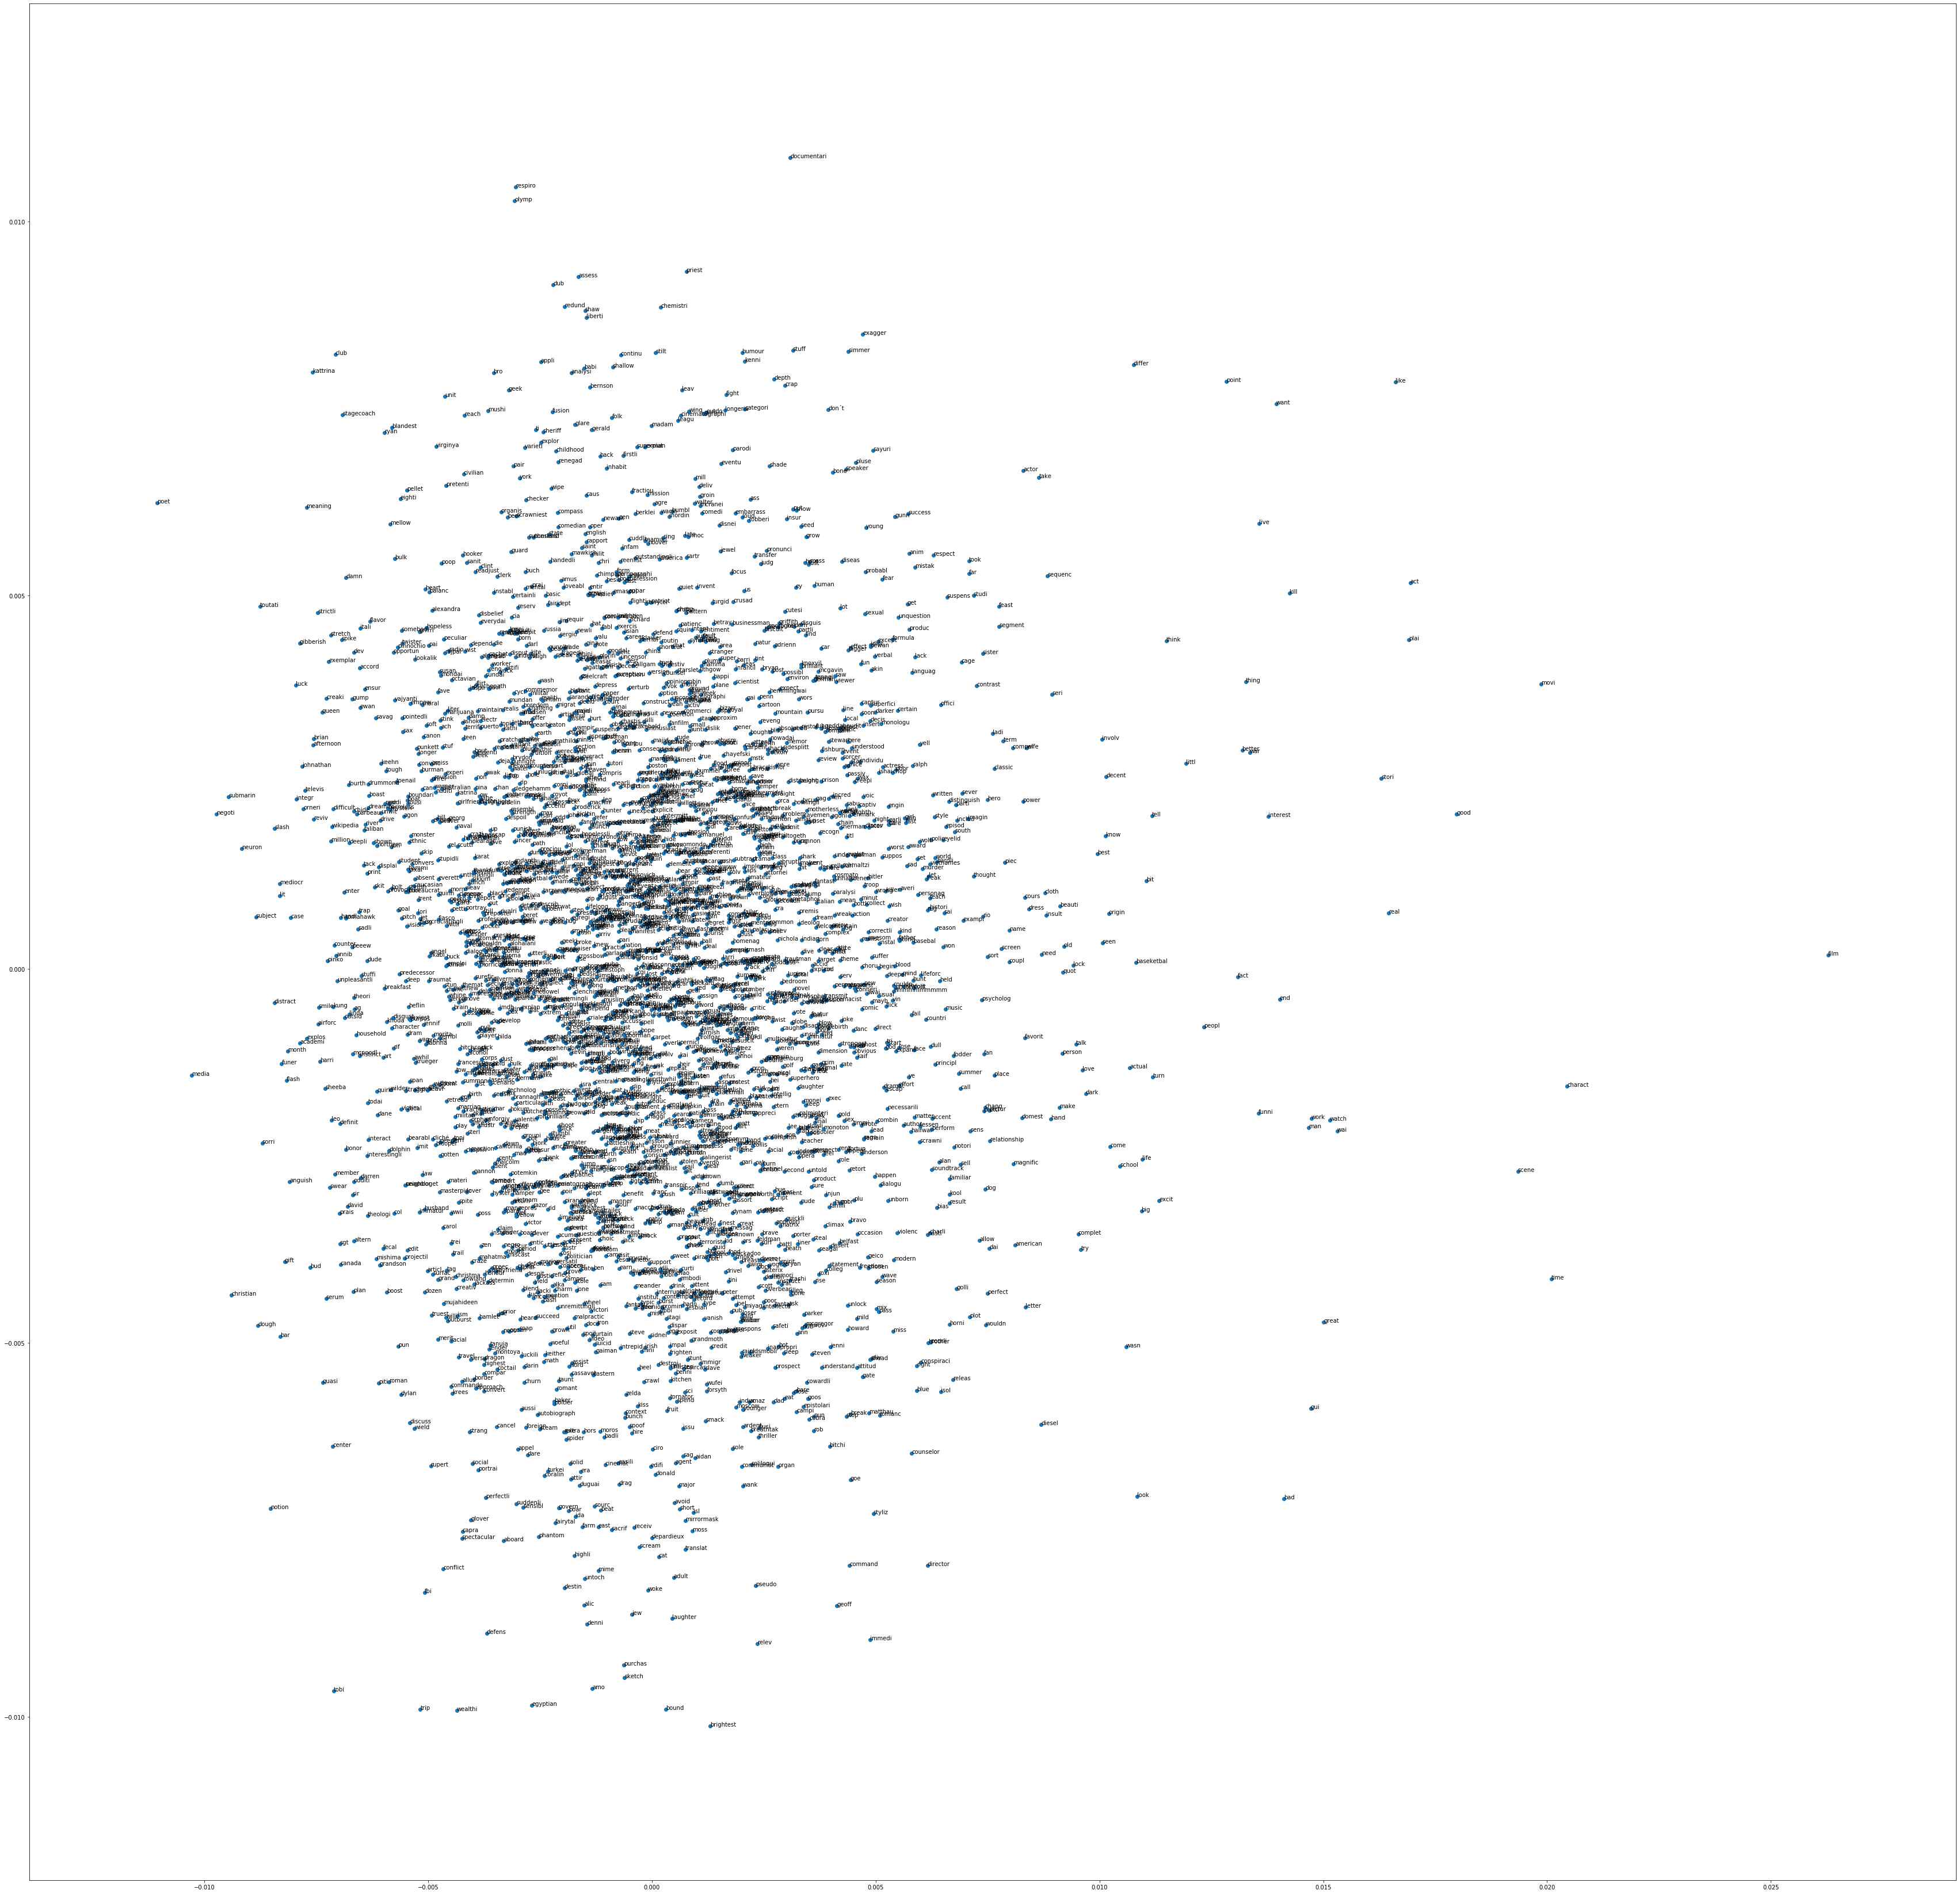

[('stori', 0.3730238080024719), ('interest', 0.36368227005004883), ('need', 0.36265552043914795), ('turn', 0.36051344871520996), ('time', 0.35119137167930603)]

[('nail', 0.36255383491516113), ('attent', 0.3468584716320038), ('nut', 0.327898234128952)]

[('submarin', 0.33715981245040894), ('krees', 0.32105517387390137), ('david', 0.30892717838287354)]



In [20]:
## PLOT AND ANALYZE DOWNSAMPLED W2V

warnings.filterwarnings("ignore")
w2v_model_small = Word2Vec.load('w2v_model_100.bin')
print(w2v_model_small)
XSmall = w2v_model_small[w2v_model_small.wv.vocab]

# fit a 2D PCA model to the vectors
pcaSmall = PCA(n_components=2)
resultSmall = pcaSmall.fit_transform(XSmall)

# create a scatter plot of the projection
plt.scatter(resultSmall[:, 0], resultSmall[:, 1])
plt.rcParams["figure.figsize"] = (60,60)
# plt.plot([-0.015,0.015], [-0.015,0.015])
wordsSmall = list(w2v_model_small.wv.vocab)
for i, word in enumerate(wordsSmall):
    plt.annotate(word, xy=(resultSmall[i, 0], resultSmall[i, 1]))
plt.savefig('w2v_100.png')
plt.show()

print(str(w2v_model_small.wv.most_similar(positive = "funni", topn = 5)) + "\n") 
print(str(w2v_model_small.wv.most_similar(positive = "director", topn = 3)) + "\n") 
#print(str(w2v_model_small.wv.most_similar(positive = ['food', 'bad'], topn = 3)) + "\n")
print(str(w2v_model_small.wv.most_similar(positive = ['woman', 'king'], negative = ['man'], topn = 3)) + "\n")

 ### 3.2 Word2Vec: Neural Net

In [21]:
## CREATE EMBEDDING MATRIX 

text_data = df['review'].values
labels = df['sentiment'].values 

docs_train, docs_test, y_train, y_test = train_test_split(text_data, labels, test_size=0.2, random_state=1000)
docs_train, docs_val, y_train, y_val = train_test_split(docs_train, y_train, test_size=0.1, random_state=1000)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(docs_train)
X_test = vectorizer.transform(docs_test)
X_val = vectorizer.transform(docs_val)

input_dim = X_train.shape[1]
print(input_dim)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(docs_train) ## ALWAYS run the tokenizer ONLY on the training set
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print(vocab_size)

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="UTF-8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

embedding_dim = 50
embedding_matrix = create_embedding_matrix('w2v_50k.txt', tokenizer.word_index, embedding_dim)

88808
106805


In [22]:
## CHEK HOW MANY OF THE WORDS WE HAVE IN TRAINING ARE IN OUR WORD EMBEDDING

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)

0.24232011609943355


In [23]:
maxlen = 88808 
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], ## specifying the weights
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 88808, 50)         5340250   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 5,340,771
Trainable params: 5,340,771
Non-trainable params: 0
_________________________________________________________________


In [24]:
tf.config.experimental.set_visible_devices([], 'GPU')

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    batch_size=50)
loss, nn_w2v_accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(nn_w2v_accuracy))

Train on 36000 samples, validate on 4000 samples
Epoch 1/10
36000/36000 [==============================] - 1437s 40ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.4935
Epoch 2/10
36000/36000 [==============================] - 1454s 40ms/step - loss: 0.6932 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy: 0.5065
Epoch 3/10
36000/36000 [==============================] - 1447s 40ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.5065
Epoch 4/10
36000/36000 [==============================] - 1451s 40ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.4935
Epoch 5/10
36000/36000 [==============================] - 1450s 40ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6931 - val_accuracy: 0.5065
Epoch 6/10
36000/36000 [==============================] - 1429s 40ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5065
Epoch 7/10
36000/36000 [===========================

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


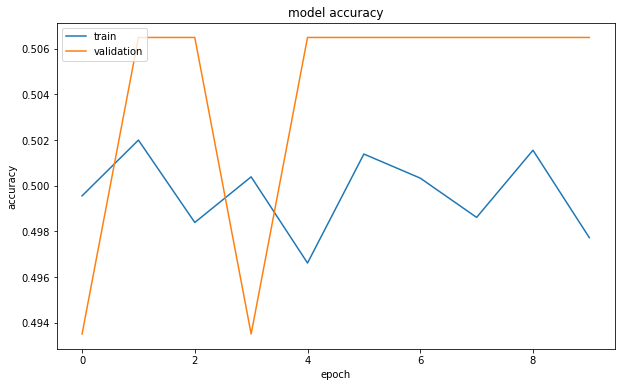

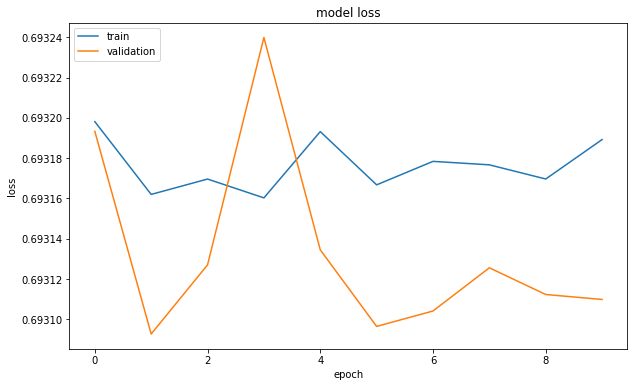

In [25]:
## PLOT NEURAL NET WITH EMBEDDING GRAPHS 

print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("nn_embedding_accuracy.png")
plt.show()
# summarize history for loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("nn_embedding_loss.png")
plt.show()

# 4. Results of All Models

In [26]:
print("Naive Bayes accuracy: " + str(accuracy_score_nb))
print("Naive Bayes Cross Validation accuracy: " + str(nb_xval_scores.mean()))
print("Logistic Regression accuracy: " + str(accuracy_score_lr))
print("Logistic Regression Cross Validation accuracy: " + str(lr_xval_scores.mean()))
print("Neural Net accuracy: " + str(nn_accuracy))
print("Neural Net with embeddings accuracy: " + str(nn_w2v_accuracy))
print("Support Vector Machine accuracy: " + str(svm_xval_scores.mean()))

Naive Bayes accuracy: 0.8415
Naive Bayes Cross Validation accuracy: 0.8499000000000001
Logistic Regression accuracy: 0.882
Logistic Regression Cross Validation accuracy: 0.88338
Neural Net accuracy: 0.8984000086784363
Neural Net with embeddings accuracy: 0.49459999799728394
Support Vector Machine accuracy: 0.72238
